# SAS Sample Code

# 1. Introduction 
This is part of my previous project aimed to develop a predictive model to detect the risk of heart disease at early state using health parameters from routime monitoring. Data wrangling, and exploratory data analyses (EDA) were performed. A logistic regression model was created to predict the risk of heart disease using the dataset. 

## 1.1. Problem identification and impact statement
***
Heart disease is the leading cause of death in the U.S. and worldwide, which produces immense health and economic burdens. In U.S., more than 600,000 people die from heart disease each year (i.e. 1 in every 4 deaths). The heart disease costs associated with heath care services, medicines, and lost productivity due to death is about $219 billion each year [(CDC 2020)](https://www.cdc.gov/heartdisease/). Studies have shown that about 1 in every 3 deaths related to heart diseases are preventable if early action is provided [(MMWR 2014)](https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6317a1.htm). Therefore identifying those at increased risk for heart disease at earliest stage is critical to reduce the mortality associated with heart failure. While genomics, proteomics, and metabolomics have emerged as promising advanced tools to assess risk of disease mechanistically, predictive model based on traditional risk factors (e.g. heath measures typically evaluated in an annual physical) remains an important clinical tool that is rapid, cost-effective, and accurate [(Mosley 2020)](https://jamanetwork.com/journals/jama/article-abstract/2761086). 

**Given a set of health parameters from routine monitoring, can we robustly predict the risk of heart disease as early as possible?**

## 1.2. Dataset description

Originally downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), the dataset used in this project was exported from from [a previous work](https://nbviewer.jupyter.org/github/hehuanliao/Springboard/blob/master/Capstone2/heart_disease_ML.ipynb) where data cleaning was performed. Below is a description of each of the 14 attributes: 


| No. | Variable name | Variable description | Data summary |
| --- | --- | --- | --- |
| 1 | age | age in years | continuous |
| 2 | sex | male or female | 0=female; 1=male |
| 3 | cp | chest pain type | 1=typical angina<br/> 2=atypical angina<br/> 3=non-anginal pain<br/> 4=asymptomatic |
| 4 | trestbps | resting blood pressure | continuous, in mmHg |
| 5 | chol | serum cholesterol | continuous |
| 6 | fbs | fasting blood sugar | 0: <=120 mg/dL<br/> 1: >120 mg/dL |
| 7 | restecg | resting electrocardiographic results | 0=normal<br/> 1=having ST-T wave abnormal<br/> 2=left ventricular hypertrophy |
| 8 | thalach | maximum heart rate achieved | continuous |
| 9 | exang | exercise induced angina | 0=no; 1=yes |
| 10 | oldpeak | ST depression induced by exercise relative to rest | continuous |
| 11 | slope | the slope of the peak exercise ST segment  | 1=upsloping<br/> 2=flat<br/> 3=downsloping |
| 12 | ca | number of major vessels colored by flouroscopy | integer, 0-3 |
| 13 | thal | thalassemia (a blood disorder) | 3=normal<br/> 6=fixed defect<br/> 7=reversable defect |
| 14 | target | diagnosis of heart disease | 0=no; 1=yes |

# 2. Data wrangling 

*Importing the dataset (in .csv format) using proc import*

In [ ]:
proc import datafile='heart_clean.csv'
            out=heart
            dbms=csv replace;
run;

*Print the top 5 observations using proc print*

In [2]:
proc print data=heart (obs=5);
run;

Obs,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


*Examing the dataset using proc contents*

In [3]:
proc contents data = heart;
run;


<span style='background:yellow'> **The dataset contains 14 variables, and 303 observations. The target variable is 'target', which has 0 and 1 (0=no heart disease, 1= has heart disease). There are 8 categorical variables (i.e. sex, cp, fbs, restecg, exang, slope, ca, thal) and 5 numeric variables (i.e. age, trestbps, chol, thalach, oldpeak).** </span>


# 3. Exploratory data analyses

*calculating summary statistics using proc means*

In [4]:
proc means data=heart NMISS N MIN MAX MEAN MEDIAN STD maxdec=2;
run;

Variable,N Miss,N,Minimum,Maximum,Mean,Median,Std Dev
age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal target,0 0 0 0 0 0 0 0 0 0 0 0 0 0,303 303 303 303 303 303 303 303 303 303 303 303 303 303,29.00 0.00 1.00 94.00 126.00 0.00 0.00 71.00 0.00 0.00 1.00 0.00 3.00 0.00,77.00 1.00 4.00 200.00 564.00 1.00 2.00 202.00 1.00 6.20 3.00 3.00 7.00 1.00,54.44 0.68 3.16 131.69 246.69 0.15 0.99 149.61 0.33 1.04 1.60 0.66 4.72 0.46,56.00 1.00 3.00 130.00 241.00 0.00 1.00 153.00 0.00 0.80 2.00 0.00 3.00 0.00,9.04 0.47 0.96 17.60 51.78 0.36 0.99 22.88 0.47 1.16 0.62 0.93 1.94 0.50


*checking the frequency of the target variable using proc freq*

In [5]:
proc freq data=heart;
table target;
run;

target,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,164,54.13,164,54.13
1,139,45.87,303,100.00


<span style='background:yellow'> **Among the 303 observations, we have 139 people that has heart disease (45.87%) and 164 people without heart disease (54.13%). The dataset is relatively balanced.** </span>

*checking the distribution of sex in each group using proc sgplot*


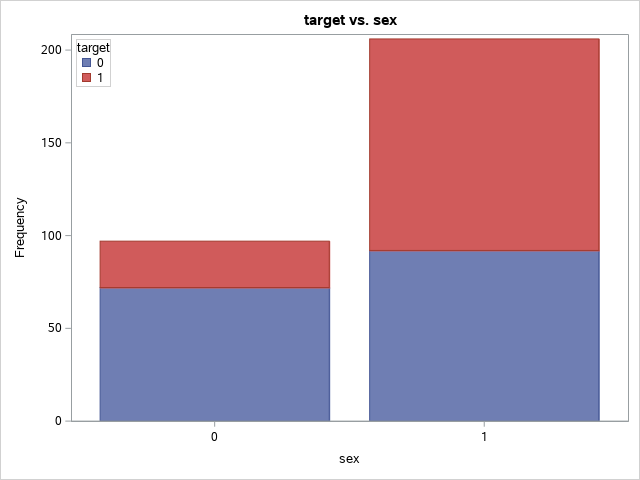

In [6]:
title 'target vs. sex';
proc sgplot data=heart;
   vbar sex / group = target;
   keylegend / location = inside position = topleft across = 1;
run;
title;

proc freq data=heart;
table sex*target;
run;

<span style='background:yellow'> **Among the 303 observations, we have more male (sex=1, n=206) than female (sex=0, n=97); among male observations, the percentage of people that had heart disease was higher than that among female observations (55.34% in male vs. 25.77% in female).** </span>

*comparing the distribution of age in the two groups using histogram*


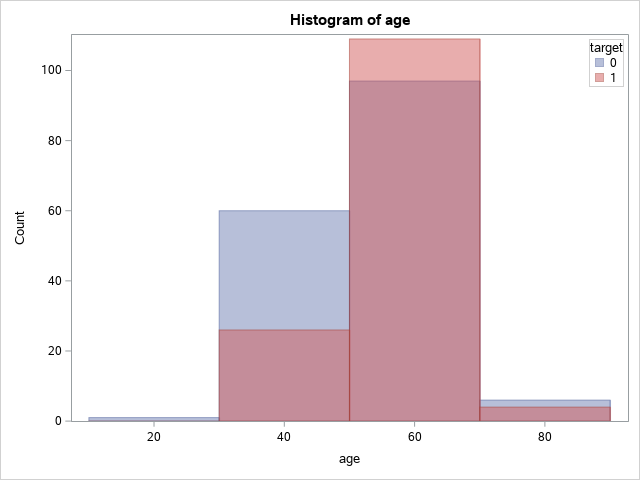

In [7]:
title 'Histogram of age';
proc sgplot data=heart;
   histogram age / nbins=4 binstart=20 binwidth=20 SHOWBINS group = target transparancy = 0.5 scale = count;
   keylegend / location = inside position = topright across = 1;
run;
title;

<span style='background:yellow'> **It seems among those with heart disease, most observations were over age 50.** </span>

*Performing Spearman's correlation analyses using proc corr*

In [8]:
proc corr data=heart spearman;
var age trestbps chol thalach oldpeak;
run;

The output includes simple statistics on each variable and a table of Spearman Correlation Coefficients (r). For example, the correlation between age and thalach (max. heart rate achieved) is -0.39163. The number under each correlation is a p-value. It tests if r is statistically significant. For example, if the p-value is small (e.g. < 0.05), then we may conclude that the relationship is statistically significant. 

<span style='background:yellow'> **no highly correlated variables (e.g. |r| > 0.7) were observed.** </span>

# 4. Building logistic regression model

***
Splitting the data into training and test set: 
<br>*using proc sort to sort out the data, and use proc surveyselect to split the data (set outall to include all observations; set samprate=0.7 to use 70:30 ratio; use strata target to keep the ratio of target at the original dataset)*

In [9]:
proc sort data=heart out=heart_sorted;
by target;
run;

proc surveyselect data=heart_sorted out=heart_survey outall
samprate=0.7 seed=52;
strata target;
run;

data train;
set heart_survey;
if selected = 1;
run;

data test;
set heart_survey;
if selected = 0;
run;

Selection Method,Simple Random Sampling
Strata Variable,target
Input Data Set,HEART_SORTED
Random Number Seed,52
Stratum Sampling Rate,0.7
Number of Strata,2
Total Sample Size,213
Output Data Set,HEART_SURVEY


*creating a frequency table to compare the ratios of the target groups in each splitted dataset*

In [10]:
proc freq data=heart_survey;
tables selected*target;
run;

<span style='background:yellow'> **From the above table, we can see the percentage of the observations with heart disease (target=1) is approximately 46% in the original dataset, which is well maintained in the splitted dataset.** </span>

***
Building logistic regression model using the training set and evaluate the model performance using the test set: 
<br>*using proc logistic (use the descending option to sort the response variable from highest to lowest, so that we model the probability of target=1; set param=ref to instruct SAS to use dummy coding for categorical variables)*


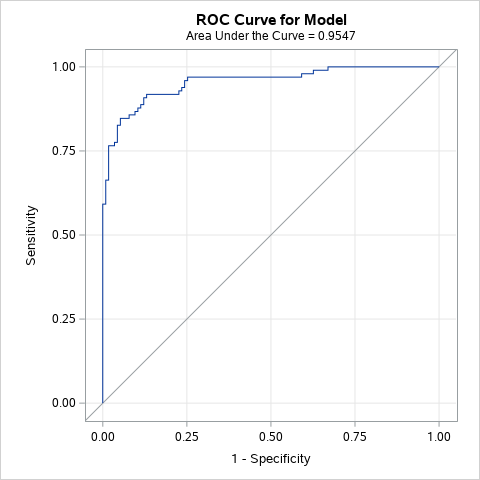
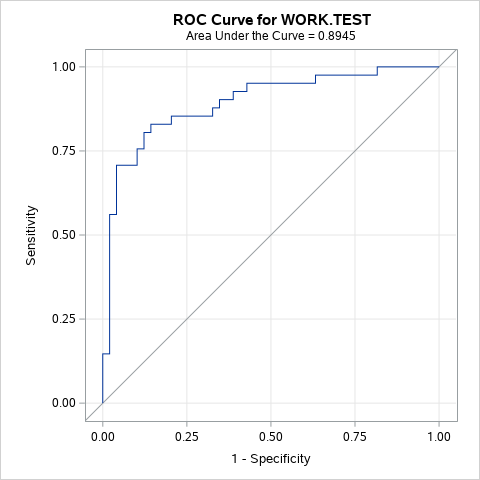

In [11]:
ods graphics on;
proc logistic data=train descending plots(only)=roc; 
class sex cp fbs restecg exang slope ca thal / param = ref;
model target = age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal / outroc=train_roc;
score data=test out = test_pred outroc=test_roc;
run;
ods graphics off;

- <span style='background:yellow'>From the table - Analysis of Maximum Likelihood Estimates, we can see the model will select sex, cp, exang, and thal as input variables (p<0.05). </span>
- <span style='background:yellow'>The AUC score ranges from 0.5 to 1, where 0.5 corresponds to a model with no predictive power, and a 1 corresponds to a perfect model. The fitted model on the training set has an AUC score of 0.9547. When applied to the test set, the AUC score is 0.8945. Therefore, we can conclude that our model performance (with a ROC-AUC of 0.8945) is quite satisfactory. </span>